# Example 5: Special functions

Let's construct a dataset which contains special functions $f(x,y)={\rm exp}(J_0(20x)+y^2)$, where $J_0(x)$ is the Bessel function.

In [1]:
from kan import KAN, create_dataset, SYMBOLIC_LIB, add_symbolic
import torch

# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[2,5,1], grid=20, k=3, seed=0)
f = lambda x: torch.exp(torch.special.bessel_j0(20*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)

# train the model
model.train(dataset, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10.);

train loss: 1.40e-01 | test loss: 1.38e-01 | reg: 2.88e+01 : 100%|██| 20/20 [00:30<00:00,  1.50s/it]


Plot trained KAN, the bessel function shows up in the bettom left

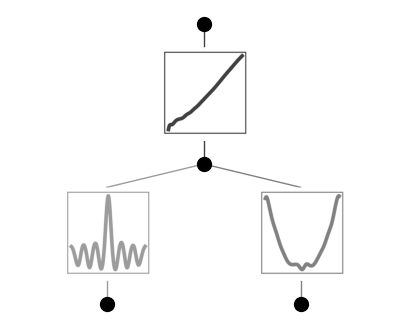

In [2]:
model = model.prune()
model(dataset['train_input'])
model.plot()

suggest_symbolic does not return anything that matches with it, since Bessel function isn't included in the default SYMBOLIC_LIB. We want to add Bessel to it.

In [3]:
model.suggest_symbolic(0,0,0)

function , r2
gaussian , 0.7090268761989152
1/x^2 , 0.21051195154680438
sin , 0.1822506022370818
abs , 0.12418544555819415
tan , 0.10407480103502795


('gaussian',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.7090268761989152)

In [4]:
SYMBOLIC_LIB.keys()

dict_keys(['x', 'x^2', 'x^3', 'x^4', '1/x', '1/x^2', '1/x^3', '1/x^4', 'sqrt', '1/sqrt(x)', 'exp', 'log', 'abs', 'sin', 'tan', 'tanh', 'sigmoid', 'sgn', 'arcsin', 'arctan', 'arctanh', '0', 'gaussian', 'cosh'])

In [5]:
# add bessel function J0 to the symbolic library
# we should include a name and a pytorch implementation
add_symbolic('J0', torch.special.bessel_j0)

After adding Bessel, we check suggest_symbolic again

In [6]:
# J0 shows up but not top 1, why?

model.suggest_symbolic(0,0,0)

function , r2
gaussian , 0.7090268761989152
J0 , 0.2681378679614782
1/x^2 , 0.21051195154680438
sin , 0.1822506022370818
abs , 0.12418544555819415


('gaussian',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.7090268761989152)

In [7]:
# This is because the ground truth is J0(20x) which involves 20 which is too large.
# our default search is in (-10,10)
# so we need to set the search range bigger in order to include 20
# now J0 appears at the top of the list

model.suggest_symbolic(0,0,0,a_range=(-40,40))

function , r2
J0 , 0.9717763100936939
gaussian , 0.7494106253678943
sin , 0.49679878395526067
1/x^2 , 0.21051195158162733
abs , 0.12435207425739554


('J0',
 (<function torch._C._special.special_bessel_j0>, J0),
 0.9717763100936939)

In [8]:
model.train(dataset, opt="LBFGS", steps=20);

train loss: 1.67e-02 | test loss: 1.80e-02 | reg: 2.87e+00 : 100%|██| 20/20 [00:08<00:00,  2.25it/s]


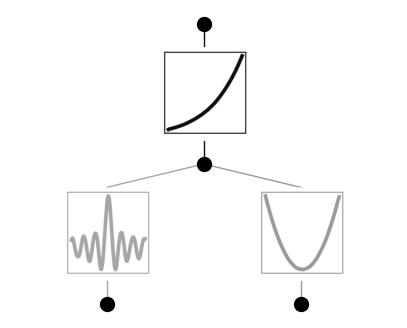

In [9]:
model.plot()

In [10]:
model.suggest_symbolic(0,0,0,a_range=(-40,40))

function , r2
J0 , 0.9985560043309399
gaussian , 0.6101756259771707
sin , 0.5737221152646913
tan , 0.08366297315238909
1/x , 0.08315973336762218


('J0',
 (<function torch._C._special.special_bessel_j0>, J0),
 0.9985560043309399)

Finish the rest of symbolic regression

In [11]:
model.fix_symbolic(0,0,0,'J0',a_range=(-40,40))

r2 is 0.9985560043309399


tensor(0.9986)

In [12]:
model.auto_symbolic()

skipping (0,0,0) since already symbolic
fixing (0,1,0) with x^2, r2=0.9999802186534139
fixing (1,0,0) with sigmoid, r2=0.9999663092809886


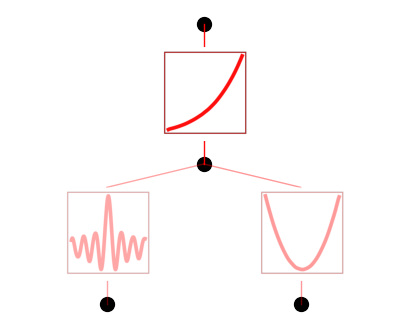

In [13]:
model.plot()

In [14]:
model.train(dataset, opt="LBFGS", steps=20);

train loss: 1.12e-03 | test loss: 1.17e-03 | reg: 4.76e+01 : 100%|██| 20/20 [00:08<00:00,  2.38it/s]


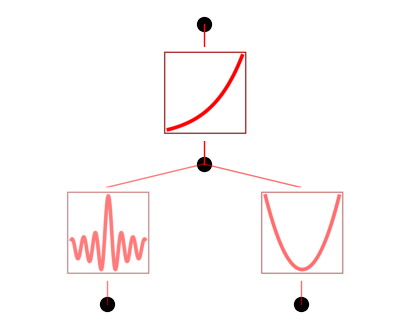

In [15]:
model.plot()

In [16]:
model.suggest_symbolic(1,0,0)

function , r2
exp , 0.9999988610586863
cosh , 0.9999699077016541
sigmoid , 0.9999693609882967
arctan , 0.9999174139339265
gaussian , 0.9999096961395885


('exp',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.9999988610586863)

In [17]:
model.fix_symbolic(1,0,0,'exp')

r2 is 0.9999988610586863


tensor(1.0000, grad_fn=<SelectBackward0>)

In [18]:
# why can't we reach machine precision (because LBFGS early stops?)? The symbolic formula is correct though.
model.train(dataset, opt="LBFGS", steps=20);
model.symbolic_formula()[0][0]

train loss: 8.09e-04 | test loss: 8.51e-04 | reg: 4.68e+01 : 100%|██| 20/20 [00:05<00:00,  3.96it/s]


1.0*exp(1.0*x_2**2 + 1.0*J0(-20.0*x_1))